In [19]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [20]:
!pip install kaggle

In [21]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [22]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [23]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
# extracting the compressed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [25]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/data')):
    subfolder_path = os.path.join('/content/data', subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 115.90it/s]


,image,label
0,/content/data/with_mask/with_mask_2639.jpg,with_mask
1,/content/data/with_mask/with_mask_2871.jpg,with_mask
2,/content/data/with_mask/with_mask_1420.jpg,with_mask
3,/content/data/with_mask/with_mask_2454.jpg,with_mask
4,/content/data/with_mask/with_mask_3090.jpg,with_mask
...,...,...
7548,/content/data/without_mask/without_mask_2806.jpg,without_mask
7549,/content/data/without_mask/without_mask_2006.jpg,without_mask
7550,/content/data/without_mask/without_mask_2913.jpg,without_mask
7551,/content/data/without_mask/without_mask_2176.jpg,without_mask


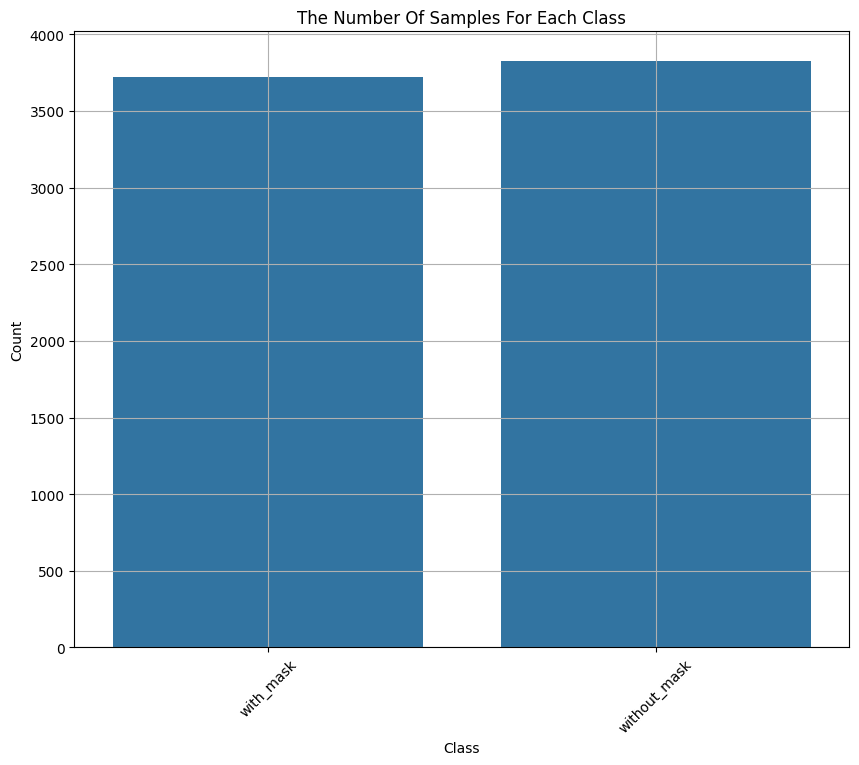

In [26]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('The Number Of Samples For Each Class')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [27]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [29]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


##DenseNet121

In [30]:
num_of_classes=2
densenet = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in densenet.layers:
    layer.trainable = False

model_DenseNet = keras.Sequential()
model_DenseNet.add(densenet)
model_DenseNet.add(keras.layers.Flatten())
model_DenseNet.add(keras.layers.Dense(128, activation='relu'))
model_DenseNet.add(keras.layers.Dropout(0.5))
model_DenseNet.add(keras.layers.Dense(64, activation='relu'))
model_DenseNet.add(keras.layers.Dropout(0.5))
model_DenseNet.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

model_DenseNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               6422656   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

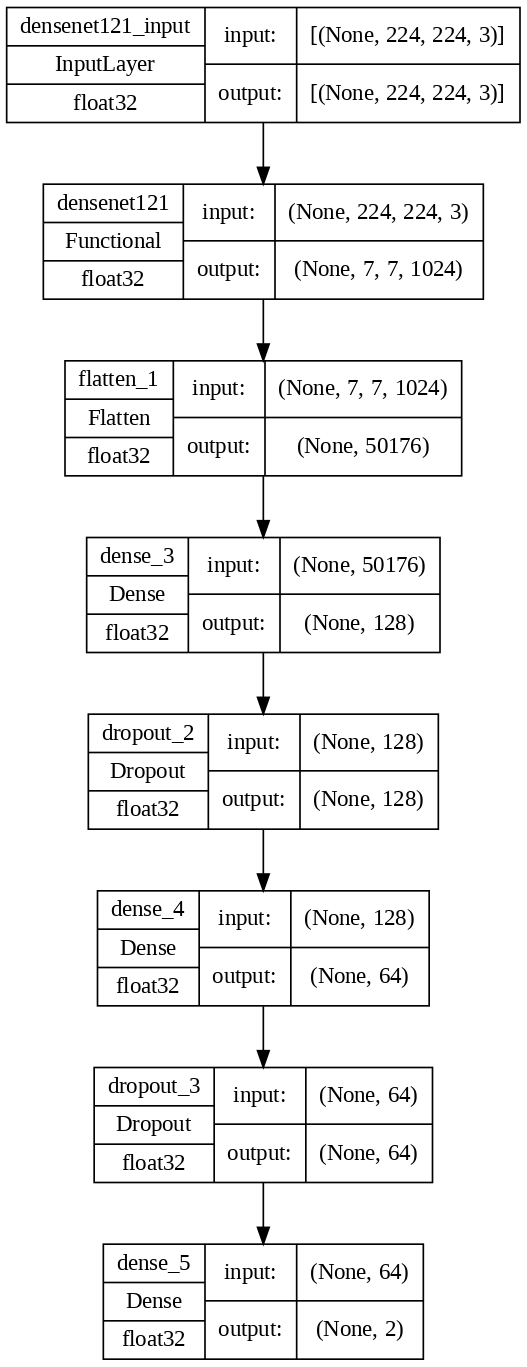

In [31]:
tf.keras.utils.plot_model(model_DenseNet, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("face_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model_DenseNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_DenseNet = model_DenseNet.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 1147s 7s/step - loss: 0.1934 - accuracy: 0.9688 - val_loss: 0.0361 - val_accuracy: 0.9823
Epoch 2/20
166/166 [==============================] - 1055s 6s/step - loss: 0.1253 - accuracy: 0.9576 - val_loss: 0.0514 - val_accuracy: 0.9894
Epoch 3/20
166/166 [==============================] - 1075s 6s/step - loss: 0.1082 - accuracy: 0.9614 - val_loss: 0.0868 - val_accuracy: 0.9921
Epoch 4/20
166/166 [==============================] - 1036s 6s/step - loss: 0.0877 - accuracy: 0.9739 - val_loss: 0.0374 - val_accuracy: 0.9868
Epoch 5/20
166/166 [==============================] - 1064s 6s/step - loss: 0.0613 - accuracy: 0.9792 - val_loss: 0.0262 - val_accuracy: 0.9912
Epoch 6/20
166/166 [==============================] - 1067s 6s/step - loss: 0.0613 - accuracy: 0.9741 - val_loss: 0.0172 - val_accuracy: 0.9938
Epoch 7/20
166/166 [==============================] - 1065s 6s/step - loss: 0.0425 - accuracy: 0.9818 - val_loss: 0.0189 - val_accuracy: 0.9938
Epo

In [ ]:
hist1_=pd.DataFrame(hist_DenseNet.history)
hist1_

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist1_['loss'],label='Train_Loss')
plt.plot(hist1_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1_['acc'],label='Train_Accuracy')
plt.plot(hist1_['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model_DenseNet.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

In [ ]:
y_test =test_generator.classes
predictions = model_DenseNet.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

In [ ]:
class_names=['with_mask', 'without_mask']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )